# Trading Insights

<IPython.core.display.Javascript object>

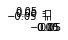

In [68]:
import datetime
import matplotlib
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
from tqdm import tqdm
# these two lines are necessary in vscode jupyter editor
plt.plot()
plt.gcf().set_size_inches((0.1, 0.1))

## Indicator Definition

In [23]:
class GridIndicator(bt.Indicator):
    params = (('period', 26),)
    lines = tuple([f'grid{i}' for i in range(9)] + ['level'])
    plotinfo = dict(subplot=False)
    
    def __init__(self) -> None:
        ma = bt.indicators.SmoothedMovingAverage(period=self.p.period)
        std = bt.indicators.StandardDeviation(period=self.p.period)
        step =  [-2.5, -2, -1.3, -1, 0, 1, 1.3, 2, 2.5]
        grid = [ma + s * std for s in step]
        for i in range(9):
            exec(f'self.lines.grid{i} = grid[{i}]')
        self.lines.level = bt.Sum(*[self.data.close >= grid[i] for i in range(9)])

## Portfolio Strategies Definition

### Simple Moving Average Strategy

When SMA5 cross up the SMA10 line, buy; when SMA5 cross down the SMA10 line, sell.

In [3]:
class MAStrategy(bt.Strategy):

    def __init__(self) -> None:
        self.ma5 = [bt.indicators.SmoothedMovingAverage(
            self.datas[i].close, period=5) for i in range(len(self.datas))]
        self.ma10 = [bt.indicators.SmoothedMovingAverage(
            self.datas[i].close, period=10) for i in range(len(self.datas))]
    
    def next(self):
        for data in self.datas:
            if self.ma5[0] > self.ma10[0] and self.ma5[-1] < self.ma10[-1]:
                print('buy')
                self.order_target_percent(data, target=0.95 / len(self.datas))
            elif self.ma5[0] <= self.ma10[0] and self.ma5[-1] > self.ma10[-1]\
                and self.getposition(data).size != 0:
                print('sell')
                self.order_target_percent(data, target=0)

### Grid Strategies

In [20]:
class GridStrategy(bt.Strategy):
    params = (('remain', 0.03), ('period', 26))
    
    def __init__(self) -> None:
        self.grids = dict(zip(
            self.getdatanames(),
            [GridIndicator(self.getdatabyname(name), period=self.p.period) for name in self.getdatanames()],
            ))
        self.order = None

    def log(self, text: str, datetime: datetime.datetime = None, hint: str = 'INFO'):
        datetime = datetime or self.data.datetime.date(0)
        print(f'[{hint}] {datetime}: {text}')

    def notify_order(self, order: bt.Order):
        if order.status in [order.Submitted, order.Accepted, order.Created]:
            return

        elif order.status in [order.Completed]:
            self.log(f'Trade <{order.executed.size}> <{order.info.get("name", "data")}> at <{order.executed.price:.2f}>')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected, order.Expired]:
            self.log('Order canceled, margin, rejected or expired', hint='WARN')

        self.order = None
        
    def next(self):
        for name, data in zip(self.getdatanames(), self.datas):
            if self.grids[name].level[0] > self.grids[name].level[-1] and self.grids[name].level[0] != 9.0 and self.getposition(data).size:
                if self.order is not None:
                    self.cancel(self.order)
                    self.order = None
                self.order = self.order_target_percent(data, target=(1 - self.p.remain) / 10 * self.grids[name].level[0] / len(self.datas),
                    exectype=bt.Order.Limit, price=eval(f'self.grids["{name}"].grid{int(self.grids[name].level[0])}'), name=name)
            elif self.grids[name].level[0] < self.grids[name].level[-1] and self.grids[name].level[0] != 0.0:
                if self.order is not None:
                    self.cancel(self.order)
                    self.order = None
                self.order = self.order_target_percent(data, target=(1 - self.p.remain) / 10 * self.grids[name].level[0] / len(self.datas),
                    exectype=bt.Order.Limit, price=eval(f'self.grids["{name}"].grid{int(self.grids[name].level[0] - 1)}'), name=name)
            # 1. judge which grid the close is in
            # 2. compare with last grid
            # 3. compare the current and the last 2 grids
            # 4. decide the position
            pass

## Single Stock Strategies Definition

### Grid Strategy in Single Stock

In [66]:
class GridStrategy(bt.Strategy):
    params = (('remain', 0.03), ('period', 26))
    
    def __init__(self) -> None:
        self.grids = GridIndicator(period=self.p.period)
        self.order = None

    def log(self, text: str, datetime: datetime.datetime = None, hint: str = 'INFO'):
        datetime = datetime or self.data.datetime.date(0)
        # print(f'[{hint}] {datetime}: {text}')

    def notify_order(self, order: bt.Order):
        if order.status in [order.Submitted, order.Accepted, order.Created]:
            return

        elif order.status in [order.Completed]:
            self.log(f'Trade <{order.executed.size}> <{order.info.get("name", "data")}> at <{order.executed.price:.2f}>')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected, order.Expired]:
            self.log('Order canceled, margin, rejected or expired', hint='WARN')

        self.order = None
        
    def next(self):
        if self.grids.level[0] > self.grids.level[-1] and self.grids.level[0] != 9.0 and self.getposition().size:
            if self.order is not None:
                self.cancel(self.order)
                self.order = None
            self.order = self.order_target_percent(target=(1 - self.p.remain) / 10 * (10 - self.grids.level[0]),
                exectype=bt.Order.Limit, price=eval(f'self.grids.grid{int(self.grids.level[0])}'))
            self.log(f"Target percentage {10 - self.grids.level[0]}, now have "
                f"{1 - self.broker.getcash() / self.broker.getvalue()}", hint="INFO")
        elif self.grids.level[0] < self.grids.level[-1] and self.grids.level[0] != 0.0:
            if self.order is not None:
                self.cancel(self.order)
                self.order = None
            self.order = self.order_target_percent(target=(1 - self.p.remain) / 10 * (10 - self.grids.level[0]),
                exectype=bt.Order.Limit, price=eval(f'self.grids.grid{int(self.grids.level[0] - 1)}'))
            self.log(f"Target percentage {10 - self.grids.level[0]}, now have "
                f"{1 - self.broker.getcash() / self.broker.getvalue()}", hint="INFO")
        # 1. judge which grid the close is in
        # 2. compare with last grid
        # 3. compare the current and the last 2 grids
        # 4. decide the position

## Data Preparation

### Multi-Stock Data Loading

In [60]:
index = pd.read_parquet('../input/index/index_weights.parquet')
index_list = index.loc(axis=0)['2022-08-04', '000016.XSHG'].index.to_list()

/var/folders/45/vgzs9vnd44bbx0x2_vrh59740000gn/T/ipykernel_84691/144928729.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_list = index.loc(axis=0)['2022-08-04', '000016.XSHG'].index.to_list()


In [62]:
data = pd.read_parquet('../input/kline-daily/market_daily.parquet')
data = data[['open', 'high', 'low', 'close', 'volume']]
data = data.loc(axis=0)[:, index_list]
data.index = data.index.remove_unused_levels()
datas = []
for d in data.index.levels[1]:
    datas.append(bt.feeds.PandasData(dataname=data.loc(axis=0)[:, d].droplevel(1), 
        fromdate=pd.to_datetime('20190101'), todate=pd.to_datetime('20200101')))

### Single Stock Data Loading

In [53]:
data = pd.read_parquet('../input/kline-daily/market_daily.parquet')
data = data[['open', 'high', 'low', 'close', 'volume']]
stock_code = "600362.XSHG"
data = data.loc(axis=0)[:, stock_code].droplevel(1)
data = bt.feeds.PandasData(dataname=data, fromdate=pd.to_datetime('20190101'), todate=pd.to_datetime('20200101'))

## Basic Settings and Initialization in backtrader

### Multi-Stock Adding

In [40]:
cerebro = bt.Cerebro()
cerebro.addindicator(GridIndicator)
cerebro.broker.set_cash(100_0000)
for i, d in enumerate(datas):
    cerebro.adddata(d, name=data.index.levels[1][i])
cerebro.addstrategy(GridStrategy, period=5)

0

### Single Stock Adding

In [57]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100_0000)
cerebro.adddata(data)
cerebro.addstrategy(GridStrategy, period=26)

0

## Run the Strategy

### Multi-Stock or Single-Stock Run for Only Once

In [58]:
cerebro.run()

[INFO] 2019-02-15: Target percentage 3.0, now have 0.0
[INFO] 2019-02-19: Target percentage 2.0, now have 0.0
[WARN] 2019-02-20: Order canceled, margin, rejected or expired
[INFO] 2019-02-21: Target percentage 2.0, now have 0.0
[INFO] 2019-02-22: Trade <13848> <data> at <14.26>
[INFO] 2019-02-22: Trade <13601> <data> at <14.26>
[INFO] 2019-02-27: Target percentage 2.0, now have 0.41614181752530854
[INFO] 2019-02-28: Trade <-14859> <data> at <15.88>
[INFO] 2019-02-28: Target percentage 3.0, now have 0.18820488689496007
[INFO] 2019-03-07: Target percentage 2.0, now have 0.20030349411099424
[WARN] 2019-03-08: Order canceled, margin, rejected or expired
[INFO] 2019-03-08: Target percentage 5.0, now have 0.18800832831406566
[INFO] 2019-03-11: Target percentage 4.0, now have 0.19201875530521928
[WARN] 2019-03-12: Order canceled, margin, rejected or expired
[INFO] 2019-03-12: Trade <12826> <data> at <15.97>
[INFO] 2019-03-13: Target percentage 5.0, now have 0.3823636540582732
[INFO] 2019-03-1

### Run for each Single Stock or Each Multi-Stock Portfolio

In [74]:
datas = pd.read_parquet('../input/kline-daily/market_daily.parquet')
datas = datas[['open', 'high', 'low', 'close', 'volume']]
stock_codes = index_list
results = {}
initial_cash = 100_0000
for stock_code in tqdm(stock_codes):
    data = datas.loc(axis=0)[:, stock_code].droplevel(1)
    data = data.loc['20190101':'20200101']
    if data.empty:
        continue
    feed = bt.feeds.PandasData(dataname=data, fromdate=pd.to_datetime('20190101'), todate=pd.to_datetime('20200101'))
    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(initial_cash)
    cerebro.adddata(feed)
    cerebro.addstrategy(GridStrategy, period=26)
    cerebro.run()
    results[stock_code] = cerebro.broker.get_value() / initial_cash - 1

100%|██████████| 50/50 [00:03<00:00, 12.87it/s]


## Show the Result / Save

### Multi-Stock Plot

In [ ]:
cerebro.plot(style='bar')
plt.gcf().set_size_inches((18, 6 * len(datas)))
# plt.gcf().savefig('test.png')

### Single Stock Plot

<IPython.core.display.Javascript object>

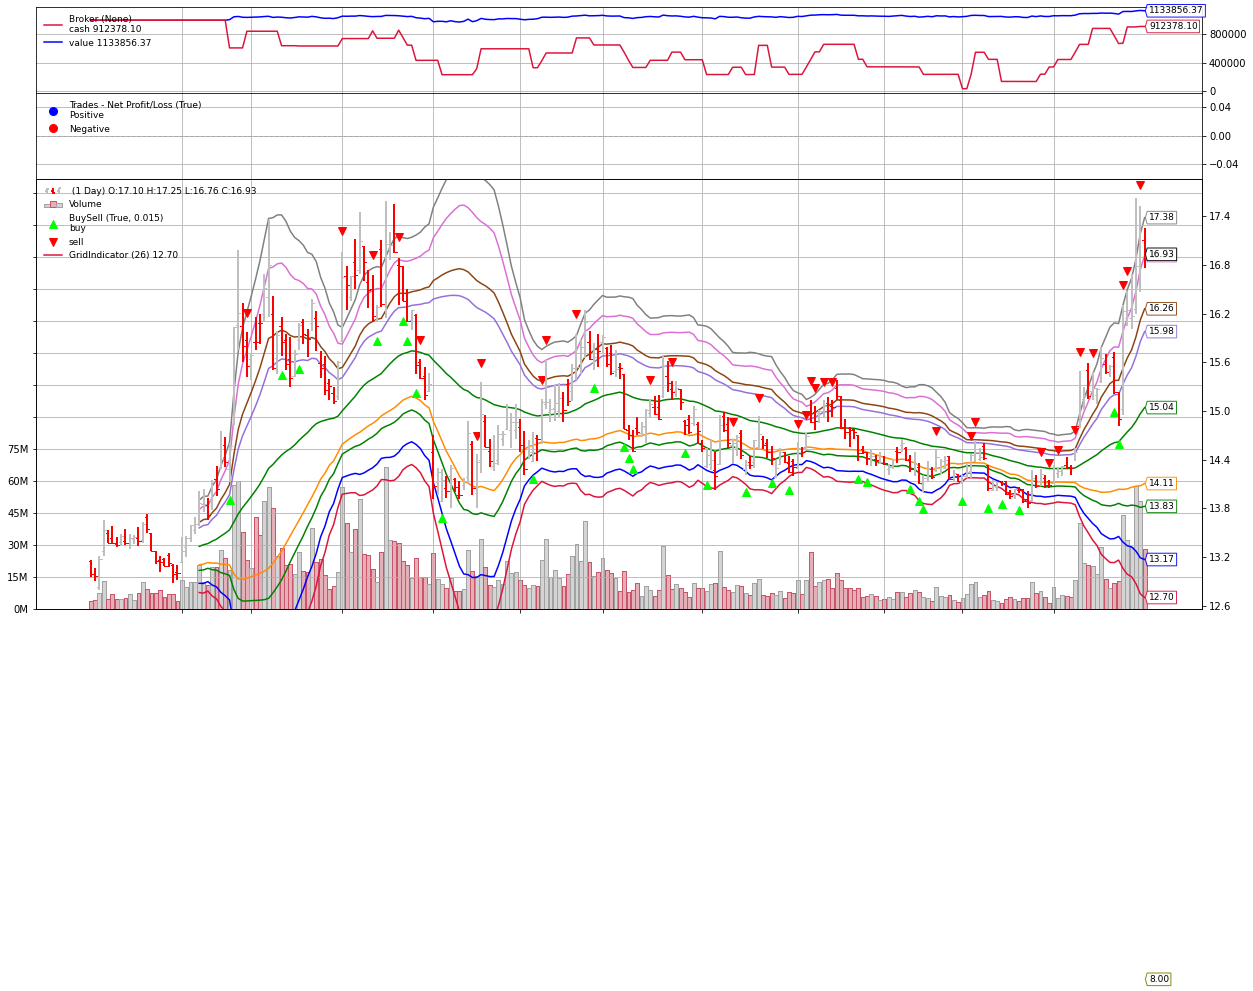

In [59]:
cerebro.plot(style='bar')
plt.gcf().set_size_inches((18, 9))
# plt.gcf().savefig('test.png')

### Stock Run One by One

In [87]:
(pd.Series(results) * index.loc["2022-08-04", "000016.XSHG"]['weight']).sum()

/var/folders/45/vgzs9vnd44bbx0x2_vrh59740000gn/T/ipykernel_84691/3220408485.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  (pd.Series(results) * index.loc["2022-08-04", "000016.XSHG"]['weight']).sum()


0.12962711856860504